In [1]:
import os, sys
import csv
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
file = '../../20191204_peptide_aptamer_pairs.csv'

## General metrics about the file

In [3]:
# Generate a dictionary from peptide --> [(aptamer, read count)]
dataset = {}
with open(file) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            print(f'Column names are {", ".join(row)}')
        else:
            peptide = row[0]
            aptamer = row[1]
            rc = row[2]
            
            # Reformat the peptide
            if '_' in peptide:
                split = peptide.split('_')
                save = split[0]
                if len(save) < 3:
                    continue
                peptide = save 
            
            if peptide not in dataset.keys():
                dataset[peptide] = []
            dataset[peptide].append((aptamer, rc))
        line_count += 1
    print("Number of lines: ", line_count)

Column names are Peptide, Aptamer, Read Count
Number of lines:  710659


In [4]:
print(str(len(dataset.keys())))

489899


## Split the dataset into binding affinity groups

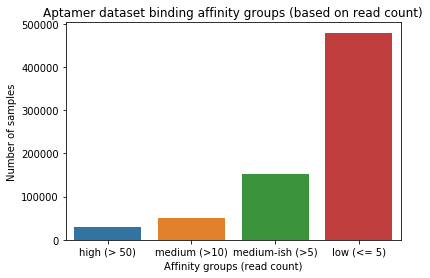

In [14]:
affinity_groups = [0, 0, 0, 0]
x = ['high (> 50)', 'medium (>10)', 'medium-ish (>5)', 'low (<= 5)']
for peptide in dataset:
    for a, r in dataset[peptide]:
        r = int(r)
        if r > 50:
            affinity_groups[0] += 1
        elif r > 10:
            affinity_groups[1] += 1
        elif r > 5:
            affinity_groups[2] += 1
        else:
            affinity_groups[3] += 1
            
plt.title("Aptamer dataset binding affinity groups (based on read count)")
plt.xlabel("Affinity groups (read count)")
plt.ylabel("Number of samples")
sns.barplot(x, affinity_groups)